In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import matplotlib.dates as mdates
import numpy as np

In [2]:
msft = yf.Ticker("MSFT")
msft_df = msft.history(start="2010-01-01", end="2025-07-25", interval="1d")
msft_df = msft_df.drop(columns=["Dividends", "Stock Splits"])
msft_df.index = msft_df.index.tz_localize(None)

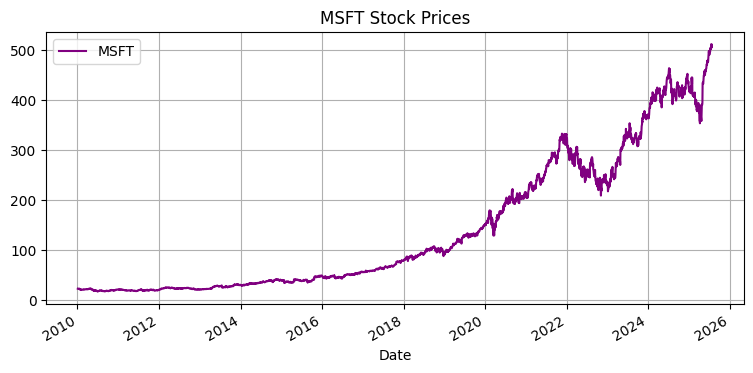

In [3]:
plt.subplots(figsize=(9, 4))
msft_df['Close'].plot(label='MSFT', color='purple')
plt.title('MSFT Stock Prices')
plt.grid()
plt.legend()